In [1]:
import re
import datetime
from operator import add

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

# APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [ ]:
# 127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839
# 127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839

# d104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985

In [3]:
def parseLogs():
    """ Read and parse log file """
#     parsed_logs = (sc
#                    .textFile('access_log_Jul95')
#                    .map(parseApacheLogLine)
#                    .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()



Number of invalid logline: 864
Invalid logline: 204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502
Invalid logline: nccse.gsfc.nasa.gov - - [01/Jul/1995:07:36:13 -0400] "GET /shuttle/missions/missions.html Shuttle Launches from Kennedy Space Center HTTP/1.0" 200 8677
Invalid logline: ix-nbw-nj1-22.ix.netcom.com - - [01/Jul/1995:10:42:09 -0400] "GET /finger @net.com HTTP/1.0" 404 -
Invalid logline: gpotterpc.llnl.gov - - [01/Jul/1995:22:26:51 -0400] "GET /htbin/wais.pl?orbit sts71 HTTP/1.0" 200 317
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com 

In [25]:
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(add)
                       .cache())
esponseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList

Found 7 response codes
Response Code Counts: [(302, 46569), (304, 132626), (500, 62), (200, 1700743), (403, 54), (501, 14), (404, 10783)]


In [8]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print [round(frac, 3) for frac in fracs]


[302, 304, 500, 200, 403, 501, 404]
[0.02, 0.07, 0.0, 0.9, 0.0, 0.0, 0.01]


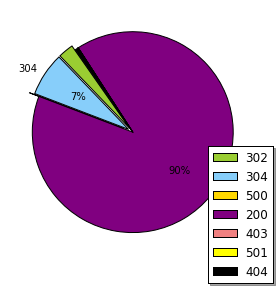

In [9]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass



In [10]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

Any 20 hosts that have accessed more then 10 times: [u'calvert.psc.rochester.edu', u'sl137.active.ch', u'slip104-134.mn.us.ibm.net', u'corning.cat.rpi.edu', u'sjackson.seanet.com', u'194.20.34.29', u'mischka.csn.tu-chemnitz.de', u'anp10.intercon.net', u'philly13.voicenet.com', u'128.158.55.143', u'pm2-01.magicnet.net', u'198.70.210.51', u'user.40.169.dcccd.edu', u'ginec01.unimo.it', u'gs1.cs.ttu.edu', u'wilma.netinfo.com.au', u'165.164.140.189', u'jabrown.remote.ualberta.ca', u'dialup96-033.swipnet.se', u'pckcb1.cad.ksc.nasa.gov']


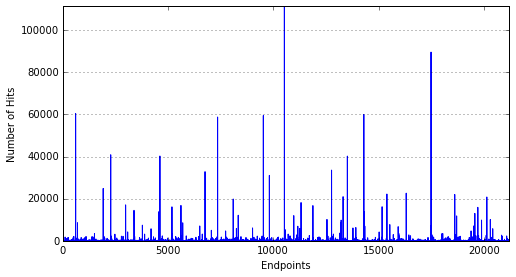

In [11]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass



## Top Ten Error Endpoints

In [17]:
not200 = access_logs.filter(lambda log: log.response_code != 200)
not200.cache()

In [21]:
endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))
# endpointCountPairTuple.take(5)
endpointSum = endpointCountPairTuple.reduceByKey(lambda x, y : x + y)
endpointSum.takeOrdered(10, key = lambda x: -x[1])

[(u'/images/NASA-logosmall.gif', 21010),
 (u'/images/KSC-logosmall.gif', 12435),
 (u'/images/MOSAIC-logosmall.gif', 6628),
 (u'/images/USA-logosmall.gif', 6577),
 (u'/images/WORLD-logosmall.gif', 6413),
 (u'/images/ksclogo-medium.gif', 5837),
 (u'/images/launch-logo.gif', 4628),
 (u'/shuttle/countdown/liftoff.html', 3509),
 (u'/shuttle/countdown/', 3345),
 (u'/shuttle/countdown/images/cdtclock.gif', 3251)]

## Number of Unique Hosts

In [22]:
hosts = access_logs.map(lambda log: (log.host, 1))

In [23]:
uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 81969


##  Number of Unique Daily Hosts

In [32]:
dayToHostPairTuple = access_logs.map(lambda log: (log.host, log.date_time.strftime("%Y%m%d")))
dayToHostPairTuple.map(lambda l: (l, 1)).reduceByKey(add).takeOrdered(10, key = lambda x: -x[1])
# dayGroupedHosts = dayToHostPairTuple.reduce()

[((u'bill.ksc.nasa.gov', '19950711'), 1394),
 ((u'indy.gradient.com', '19950712'), 1356),
 ((u'siltb10.orl.mmc.com', '19950721'), 1354),
 ((u'bill.ksc.nasa.gov', '19950712'), 1317),
 ((u'piweba3y.prodigy.com', '19950716'), 1280),
 ((u'piweba4y.prodigy.com', '19950716'), 1269),
 ((u'piweba3y.prodigy.com', '19950713'), 1202),
 ((u'piweba3y.prodigy.com', '19950704'), 1199),
 ((u'rush.internic.net', '19950713'), 1119),
 ((u'piweba3y.prodigy.com', '19950703'), 1067)]

In [38]:
from operator import add
access_logs.map(lambda log: (log.date_time.strftime("%Y%m%d"), 1)).reduceByKey(add).take(40)


[('19950714', 84101),
 ('19950720', 66589),
 ('19950701', 64710),
 ('19950713', 133952),
 ('19950707', 87208),
 ('19950715', 45512),
 ('19950723', 39195),
 ('19950709', 35261),
 ('19950725', 62698),
 ('19950706', 100956),
 ('19950716', 47846),
 ('19950722', 35256),
 ('19950708', 38861),
 ('19950724', 64251),
 ('19950705', 94572),
 ('19950717', 74976),
 ('19950727', 61674),
 ('19950704', 70444),
 ('19950710', 72852),
 ('19950718', 64265),
 ('19950726', 58843),
 ('19950703', 89542),
 ('19950711', 80315),
 ('19950728', 27118),
 ('19950721', 64627),
 ('19950702', 60260),
 ('19950712', 92230),
 ('19950719', 72737)]